In [72]:
import torch
import gym 
from tqdm import tqdm 
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Look at the Acrobot environment (2 joints swinging) 
https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py 

* 3 Discrete actions:  The action is either applying +1, 0 or -1 torque on the joint between

* State has dimension 6: sin and cos of joints + angular velocity of joints 

In [54]:
env = gym.make('Acrobot-v1')
print('Action space: ', env.action_space) 
print('State space: ', env.observation_space)

Action space:  Discrete(3)
State space:  Box(6,)


TD(0) loss is delta 

In [69]:
class ValueMLP(torch.nn.Module):
    def __init__(self, input_size, l1_size, l2_size, 
                 lr, output_size=1): 
        super(ValueMLP, self).__init__()
        self.l1 = torch.nn.Linear(input_size, l1_size)
        self.l2 = torch.nn.Linear(l1_size, l2_size) 
        self.out = torch.nn.Linear(l2_size, output_size)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x): 
        l1 = torch.relu(self.l1(x))
        l2 = torch.relu(self.l2(l1))
        pred = self.out(l2) 
        return pred 
    

class TDAgent(): 
    def __init__(self, input_size, l1_size, l2_size, 
                 lr, gamma, 
                 iterations, max_steps_per_episode, env=env): 
        self.input_size = input_size
        self.l1_size = l1_size 
        self.l2_size = l2_size 
        self.lr = lr 
        self.gamma = gamma 
        self.iterations = iterations 
        self.max_steps_per_episode = max_steps_per_episode
        self.cuda0 = torch.device('cuda:0')
        self.mlp = ValueMLP(self.input_size, 
                            self.l1_size, self.l2_size, self.lr) 
        
    
    def cuda_tensor(self, val): 
        return torch.tensor(val, dtype=torch.float32, device=self.cuda0)
    
    def train(self):
        self.mlp.cuda() 
              
        losses = [] 
        for i in range(self.iterations): 
            observation = env.reset() 
            episode_loss = 0 
            
            for j in range(self.max_steps_per_episode): 
                # zero out gradients
                self.mlp.optimizer.zero_grad() 
                episode_loss = 0 
                
                action = env.action_space.sample()
                new_obs, reward, done, info = env.step(action)
                
                # Convert floats to tensor 
                observation = self.cuda_tensor(observation) 
                new_obs = self.cuda_tensor(new_obs)
                reward = self.cuda_tensor(reward)
                
                # predict values 
                value_obs = self.mlp(observation) 
                value_new_obs = self.mlp(new_obs) 
                
                delta = reward + self.gamma * value_new_obs * (1-done) - value_obs
                episode_loss += delta 
                observation = new_obs 
                
                delta.backward() 
                self.mlp.optimizer.step() 
                
                if done: 
                    losses.append(episode_loss.item()) 
                    if i % 10 == 0: 
                        print(f'Episode {i} Total steps: {j} Loss: {episode_loss.item()}')
                    break
        return losses 
            
        
        
        

In [70]:
input_size = 6
l1_size = 1024 
l2_size = 512 
lr = 1e-5 
gamma = 0.99 
iterations = 1000 
max_steps_per_episode = 2000 

agent = TDAgent(input_size, l1_size, l2_size, lr, gamma, 
                iterations, max_steps_per_episode)
print(agent.mlp) 
losses = agent.train() 

ValueMLP(
  (l1): Linear(in_features=6, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)
Episode 0 Total steps: 499 Loss: -1.039920449256897
Episode 10 Total steps: 499 Loss: -2.198887825012207
Episode 20 Total steps: 499 Loss: -4.031208515167236
Episode 30 Total steps: 499 Loss: -5.064327239990234
Episode 40 Total steps: 499 Loss: -9.616744995117188
Episode 50 Total steps: 499 Loss: -15.986920356750488
Episode 60 Total steps: 499 Loss: -18.8606014251709
Episode 70 Total steps: 499 Loss: -22.787410736083984
Episode 80 Total steps: 499 Loss: -22.020475387573242
Episode 90 Total steps: 499 Loss: -24.691686630249023
Episode 100 Total steps: 499 Loss: -27.42555046081543
Episode 110 Total steps: 499 Loss: -32.116607666015625
Episode 120 Total steps: 499 Loss: -75.19561004638672
Episode 130 Total steps: 499 Loss: -70.4946517944336
Episode 140 Total steps: 499 Loss: -53.29037094116211
Epis

Text(0, 0.5, 'Loss')

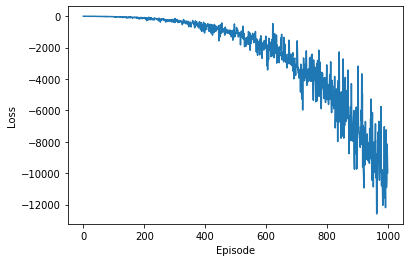

In [73]:
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')

### Actor Critic 

In [ ]:
class ActorMLP(ValueMLP): 
    def __init__(self, **kwargs):
        super(ActorMLP, self).__init__(**kwargs) 
    
    def forward(self, x): 
        l1 = torch.relu(self.l1(x))
        l2 = torch.relu(self.l2(l1))
        pred = torch.softmax(self.out(l2)) 
        

class ActorCriticAgent(TDAgent):
    def __init__(self, **kwargs): 
        super(TDAgent, self).__init__(**kwargs)
        
    def sample_action(self): 
        pass 
    
    def train(): 
        actor = ActorMLP(input_size=input_size, l1_size=l1_size, l2_size=l2_size, 
                         output_size=num_actions, lr=self.lr)
        critic = ValueMLP(input_size=input_size, l1_size=l1_size, l2_size=l2_size, 
                         output_size=1, lr=self.lr)
        print(actor)
        print(critic) 
        
        actor.cuda() 
        critic.cuda()
        
        for i in range(self.iterations): 
            observation = env.reset() 
            episode_losses = [] 
            
            for j in range(self.max_steps_per_iteration): 
                episode_loss = 0 
                actor.optimizer.zero_grad() 
                critic.optimizer.zero_grad() 
                
                observation = self.cuda_tensor(observation) 
                actor_pred = actor(mlp).item()  
                
                new_obs, reward, done, info = env.
                
            
        

In [81]:
import numpy as np 
x = [44, 42, 38]
exp_x = [np.exp(i) for i in x]
exp_x[1] / sum(exp_x)

0.11894323591065209